In [398]:
import pandas as pd
import csv
import numpy as np
import scipy
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=20,10
import matplotlib.mlab as mlab
from IPython.display import display
pd.options.display.max_columns = None
from numpy import random
from statsmodels import robust
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import itertools
import networkx as nx

In [33]:
gtex_shortlisted_w_genes = pd.read_csv('gtex_shortlisted_w_genes.tsv',sep='\t')
#gtex_shortlisted_w_genes_longformat = pickle.load( open( "gtex_shortlisted_w_genes_longformat.p", "rb" ) )
#gene_exp_dict = pickle.load( open( "gene_exp_dict.p", "rb" ) )
gene_tissue_expression_dict = pickle.load( open( "gene_tissue_expression_dict.p", "rb" ) )

In [4]:
sampleid_mapping = pd.read_csv('GTEx_Tissue_Attributes.csv',sep='\t')
sampleid_mapping.head()

SAMPID            SMTS                   SMTSD  \
0  GTEX-1117F-0003-SM-58Q7G           Blood             Whole Blood   
1  GTEX-1117F-0003-SM-5DWSB           Blood             Whole Blood   
2  GTEX-1117F-0003-SM-6WBT7           Blood             Whole Blood   
3  GTEX-1117F-0226-SM-5GZZ7  Adipose Tissue  Adipose - Subcutaneous   
4  GTEX-1117F-0426-SM-5EGHI          Muscle       Muscle - Skeletal   

                                          SAMPLENAME  
0         GTEX-1117F-0003-SM-58Q7G_Blood_Whole Blood  
1         GTEX-1117F-0003-SM-5DWSB_Blood_Whole Blood  
2         GTEX-1117F-0003-SM-6WBT7_Blood_Whole Blood  
3  GTEX-1117F-0226-SM-5GZZ7_Adipose Tissue_Adipos...  
4  GTEX-1117F-0426-SM-5EGHI_Muscle_Muscle - Skeletal

In [9]:
sampleid_mapping_rev_dist = {key:[] for key in set(sampleid_mapping['SMTS'])}
for index,row in sampleid_mapping.iterrows():
    key = row['SMTS']
    val = row ['SAMPID']
    sampleid_mapping_rev_dist[key].append(val)

In [209]:
sampleid_mapping_rev_dist['Kidney']

['GTEX-11GS4-2326-SM-5A5KS',
 'GTEX-11OF3-1326-SM-5N9FJ',
 'GTEX-11PRG-2226-SM-5GU5R',
 'GTEX-11TTK-1926-SM-5PNW8',
 'GTEX-12696-0926-SM-5FQTV',
 'GTEX-12WSG-0826-SM-5EQ5A',
 'GTEX-13112-2126-SM-5GCO4',
 'GTEX-1399S-0526-SM-5IJG8',
 'GTEX-13NYB-1726-SM-5N9G2',
 'GTEX-13O1R-2526-SM-5N9FW',
 'GTEX-13OVI-1126-SM-5KLZF',
 'GTEX-13OVL-1826-SM-5KLZR',
 'GTEX-13OW6-1826-SM-5N9F9',
 'GTEX-13RTJ-2226-SM-5S2Q1',
 'GTEX-145MN-0326-SM-5QGQI',
 'GTEX-147F4-2626-SM-5Q5CS',
 'GTEX-1497J-0826-SM-5NQAJ',
 'GTEX-14C39-2126-SM-664OH',
 'GTEX-14C5O-2026-SM-5YYB1',
 'GTEX-14E6D-2526-SM-5YYA9',
 'GTEX-15CHQ-2126-SM-6871M',
 'GTEX-15DYW-2026-SM-6AJBD',
 'GTEX-15TU5-2226-SM-6LPI2',
 'GTEX-16MT8-1926-SM-7EPGL',
 'GTEX-17F97-1926-SM-7IGM4',
 'GTEX-17HHY-2326-SM-7KFSR',
 'GTEX-1A3MW-2226-SM-73KUX',
 'GTEX-1AX8Z-2326-SM-731CR',
 'GTEX-1BAJH-1826-SM-731DA',
 'GTEX-1C6VQ-2326-SM-7IGN1',
 'GTEX-1EKGG-2226-SM-7IGOA',
 'GTEX-N7MS-1626-SM-3LK5F',
 'GTEX-NPJ8-2226-SM-3TW8D',
 'GTEX-P4QS-1126-SM-3NMD5',
 'GTEX-QDVN-1626-

In [79]:
hippie = pd.read_csv('hippie_current.txt',sep = '\t',header=None)
hippie.columns = ['Gene1', 'Gene1_Entrezid', 'Gene2', 'Gene2_Entrezid' ,'PPI_val', 'Procedure']

In [112]:
gtex_shortlisted_w_genes.shape

(939, 11689)

In [17]:
gtex_shortlisted_w_genes.head()

Gene  GTEX-1117F-0226-SM-5GZZ7  GTEX-1117F-0426-SM-5EGHI  \
0    SKI                     89.65                    35.850   
1   H6PD                     86.30                    87.030   
2  KIF1B                     18.85                    41.200   
3   MTOR                     12.64                    13.530   
4  MTHFR                     24.41                     5.453   

   GTEX-1117F-0526-SM-5EGHJ  GTEX-1117F-0626-SM-5N9CS  \
0                     90.04                     97.61   
1                     80.86                     54.98   
2                     23.81                     15.06   
3                     14.65                     15.24   
4                     21.92                     14.51   

   GTEX-1117F-0726-SM-5GIEN  GTEX-1117F-1326-SM-5EGHH  \
0                    35.320                    43.530   
1                    21.610                    36.490   
2                     6.883                     8.626   
3                     6.278                     9.213   
4                     9.886                     9.271   

   GTEX-1117F-2226-SM-5N9CH  GTEX-1117F-2426-SM-5EGGH  \
0                    63.060                    104.80   
1                   157.500                     75.65   
2                    22.750                     22.95   
3                     9.587                     22.47   
4                    15.850                     12.67   

   GTEX-1117F-2526-SM-5GZY6  GTEX-1117F-2826-SM-5GZXL  \
0                     44.47                    51.180   
1                     25.62                    36.370   
2                     16.40                    12.810   
3                     14.78                    14.880   
4                      5.92                     8.125   

   GTEX-1117F-2926-SM-5GZYI  GTEX-1117F-3026-SM-5GZYU  \
0                    43.150                    54.120   
1                    28.850                    48.380   
2                    12.710                    12.780   
3                     8.956                    16.450   
4                     6.868                     9.108   

   GTEX-1117F-3226-SM-5N9CT  GTEX-111CU-0126-SM-5GZWZ  \
0                    21.710                     22.36   
1                     7.019                     47.70   
2                    46.200                     12.94   
3                    10.550                     12.33   
4                     7.197                     11.70   

   GTEX-111CU-0226-SM-5GZXC  GTEX-111CU-0326-SM-5GZXO  \
0                     56.34                     75.31   
1                     31.41                     31.74   
2                     13.21                     11.01   
3                     21.00                     17.82   
4                     16.97                     27.34   

   GTEX-111CU-0426-SM-5GZY1  GTEX-111CU-0526-SM-5EGHK  \
0                    51.360                     9.514   
1                    47.650                    12.480   
2                     9.084                     7.696   
3                    17.500                     6.572   
4                    19.100                     4.948   

   GTEX-111CU-0626-SM-5EGHL  GTEX-111CU-0726-SM-5GZYD  \
0                     89.06                    36.100   
1                     28.81                    22.870   
2                     19.81                    18.720   
3                     21.91                    16.170   
4                     10.78                     9.118   

   GTEX-111CU-0826-SM-5EGIJ  GTEX-111CU-0926-SM-5EGIK  \
0                     85.61                    24.590   
1                     34.84                    22.080   
2                     14.53                     6.268   
3                     19.58                    14.200   
4                     14.84                    12.310   

   GTEX-111CU-1026-SM-5EGIL  GTEX-111CU-1126-SM-5EGIM  \
0                    58.610                     69.25   
1                    20.740                     66.92   
2                 

In [80]:
hippie.head()

Gene1  Gene1_Entrezid        Gene2  Gene2_Entrezid  PPI_val  \
0  AL1A1_HUMAN             216  AL1A1_HUMAN             216     0.76   
1   ITA7_HUMAN            3679   ACHA_HUMAN            1134     0.73   
2   NEB1_HUMAN           55607   ACTG_HUMAN              71     0.65   
3   SRGN_HUMAN            5552   CD44_HUMAN             960     0.63   
4   GRB7_HUMAN            2886  ERBB2_HUMAN            2064     0.90   

                                           Procedure  
0  experiments:in vivo,Two-hybrid;pmids:12081471,...  
1  experiments:in vivo,Affinity Capture-Western,a...  
2  experiments:in vitro,in vivo;pmids:9362513,120...  
3  experiments:in vivo;pmids:9334256,16189514,167...  
4  experiments:in vitro,in vivo,Reconstituted Com...

In [108]:
def neighbor_list(gene, hippie):
    #print(gene)
    x = hippie.loc[(hippie['Gene1'] == str(gene) +'_HUMAN') | (hippie['Gene2'] == str(gene) +'_HUMAN')]
    x = x.dropna()
    rows_x, cols_x = x.shape
    if rows_x < 1:
        #print(gene)
        #print('No neighbors found!')
        return [str(gene)]
    
    y = set(list(x['Gene1']) + list(x['Gene2']))
    z = []
    for i in y:
        
        tokens = i.split('_')
        if tokens[1] == 'HUMAN':
            z.append(tokens[0])
    z.append(str(gene))
    return z

master_gene_list = []
no_neighbors = []
count = 0
for gene in list(gtex_shortlisted_w_genes['Gene']):
    count+=1
    gl = neighbor_list(gene, hippie)
    if len(gl) < 2:
        no_neighbors.append(gl[0])
    master_gene_list+=gl
    if count%50 == 0:
        print(count)
    
master_gene_list = set(master_gene_list)
    

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900


In [113]:
len(master_gene_list)

9709

In [114]:
type(master_gene_list)

set

In [297]:
hippie.loc[(hippie['Gene1'] == str('JAG1') +'_HUMAN') | (hippie['Gene2'] == str('JAG1') +'_HUMAN')]
#hippie[hippie['Gene1'].isnull()]


Gene1  Gene1_Entrezid        Gene2  Gene2_Entrezid  \
4264                 JAG1_HUMAN             182  NOTC1_HUMAN            4851   
6662                 JAG1_HUMAN             182  NOTC2_HUMAN            4853   
6672                 JAG1_HUMAN             182  NOTC3_HUMAN            4854   
10012                MFNG_HUMAN            4242   JAG1_HUMAN             182   
25337                JAG1_HUMAN             182  OFUT1_HUMAN           23509   
30181                JAG1_HUMAN             182   TSP1_HUMAN            7057   
36626                JAG1_HUMAN             182   AFAD_HUMAN            4301   
64831                JAG1_HUMAN             182  AT1A1_HUMAN             476   
82621   NEU1A_HUMAN,NEUL1_HUMAN            9148   JAG1_HUMAN             182   
86966                JAG1_HUMAN             182   MIB1_HUMAN           57534   
88243                JAG1_HUMAN             182    HGS_HUMAN            9146   
109619               JAG1_HUMAN             182   CALX_HUMAN             821   
109670               JAG1_HUMAN             182   CALR_HUMAN             811   
125197               JAG1_HUMAN             182  FBXW7_HUMAN           55294   
130987              ADA17_HUMAN            6868   JAG1_HUMAN             182   
131331               JAG1_HUMAN             182    MCP_HUMAN            4179   
188191               DLL4_HUMAN           54567   JAG1_HUMAN             182   
191486               HES1_HUMAN            3280   JAG1_HUMAN             182   
191981               JAG1_HUMAN             182   JAG2_HUMAN            3714   
297528              APBB1_HUMAN             322   JAG1_HUMAN             182   

        PPI_val                                          Procedure  
4264       0.97  experiments:in vitro,in vivo,Reconstituted Com...  
6662       0.89  experiments:in vitro,in vivo,Affinity Capture-...  
6672       0.89  experiments:in vitro,in vivo,Reconstituted Com...  
10012      0.52  experiments:in vivo;pmids:12036964;sources:HPR...  
25337      0.52  experiments:in vivo;pmids:12036964;sources:HPR...  
30181      0.63  experiments:Two-hybrid;pmids:15258909;sources:...  
36626      0.70  experiments:Two-hybrid;pmids:9707552;species:R...  
64831      0.63  experiments:Two-hybrid;pmids:19293945;sources:...  
82621      0.72  experiments:enzymatic study,affinity chromatog...  
86966      0.87  experiments:affinity chromatography technology...  
88243      0.63  experiments:affinity chromatography technology...  
109619     0.63  experiments:anti tag coimmunoprecipitation;pmi...  
109670     0.63  experiments:anti tag coimmunoprecipitation;pmi...  
125197     0.63  experiments:affinity chromatography technology...  
130987     0.49                      pmids:23375636;sources:IntAct  
131331     0.79  experiments:enzyme linked immunosorbent assay,...  
188191     0.00                                     sources:STRING  
191486     0.00                                     sources:STRING  
191981     0.00                                     sources:STRING  
297528     0.63  experiments:affinity chromatography technology...

In [160]:
#shortlisting only the required genes from the whole samplespace

# gtex_data_hippie_list = pd.DataFrame()
# count = 0
# with open('GTEx_TPMS_data_skiptop2rows.tsv') as csvfile:
#     reader = csv.DictReader(csvfile, delimiter='\t')
#     for row in reader:
#         count+=1
#         if count % 500 == 0:
#             print(count)
#         if row['Description'] in master_gene_list:
#             gtex_data_hippie_list = gtex_data_hippie_list.append(row, ignore_index=True)
#gtex_data_hippie_list = gtex_data_hippie_list.rename(index=str,columns={'Description':'Gene'})
##### you can drop based on ensembl id also, here i have dropped the gene - JAG1 - based on index
#gtex_data_hippie_list = gtex_data_hippie_list.drop(gtex_data_hippie_list.index[4651])
#gtex_data_hippie_list.to_csv("gtex_data_hippie_list.tsv",sep="\t",index = False)

In [382]:
gtex_data_hippie_list[gtex_data_hippie_list['Gene'] == 'MYOD1']

Gene  GTEX-1117F-0226-SM-5GZZ7  GTEX-1117F-0426-SM-5EGHI  \
2701  MYOD1                   0.03415                     4.544   

      GTEX-1117F-0526-SM-5EGHJ  GTEX-1117F-0626-SM-5N9CS  \
2701                       0.0                       0.0   

      GTEX-1117F-0726-SM-5GIEN  GTEX-1117F-1326-SM-5EGHH  \
2701                       0.0                       0.0   

      GTEX-1117F-2226-SM-5N9CH  GTEX-1117F-2426-SM-5EGGH  \
2701                   0.03416                       0.0   

      GTEX-1117F-2526-SM-5GZY6  GTEX-1117F-2826-SM-5GZXL  \
2701                   0.02615                       0.0   

      GTEX-1117F-2926-SM-5GZYI  GTEX-1117F-3026-SM-5GZYU  \
2701                       0.0                       0.0   

      GTEX-1117F-3226-SM-5N9CT  GTEX-111CU-0126-SM-5GZWZ  \
2701                    0.1359                    0.0358   

      GTEX-111CU-0226-SM-5GZXC  GTEX-111CU-0326-SM-5GZXO  \
2701                   0.08866                       0.0   

      GTEX-111CU-0426-SM-5GZY1  GTEX-111CU-0526-SM-5EGHK  \
2701                   0.01809                       0.0   

      GTEX-111CU-0626-SM-5EGHL  GTEX-111CU-0726-SM-5GZYD  \
2701                   0.02578                   0.06195   

      GTEX-111CU-0826-SM-5EGIJ  GTEX-111CU-0926-SM-5EGIK  \
2701                   0.05788                       0.0   

      GTEX-111CU-1026-SM-5EGIL  GTEX-111CU-1126-SM-5EGIM  \
2701                   0.03613                       0.0   

      GTEX-111CU-1226-SM-5EGIN  GTEX-111CU-1326-SM-5NQ8L  \
2701                       0.0                       0.0   

      GTEX-111CU-1426-SM-5GZYP  GTEX-111CU-1526-SM-5N9FS  \
2701                   0.05612                       0.0   

      GTEX-111CU-1726-SM-5EGHM  GTEX-111CU-1826-SM-5GZYN  \
2701                     1.076                   0.05487   

      GTEX-111CU-2026-SM-5GZZC  GTEX-111CU-2226-SM-5N9G5  \
2701                     29.16                       0.0   

      GTEX-111FC-0126-SM-5N9DL  GTEX-111FC-0226-SM-5N9B8  \
2701                   0.03349                       0.0   

      GTEX-111FC-0326-SM-5GZZ1  GTEX-111FC-0426-SM-5N9CV  \
2701                     29.54                       0.0   

      GTEX-111FC-0526-SM-5GZZ8  GTEX-111FC-0626-SM-5N9CU  \
2701                   0.09636                   0.04861   

      GTEX-111FC-0826-SM-5GZWO  GTEX-111FC-1026-SM-5GZX1  \
2701                    0.1044                   0.08039   

      GTEX-111FC-1126-SM-5GZWU  GTEX-111FC-1326-SM-5N9D9  \
2701                   0.06522                   0.02504   

      GTEX-111FC-1926-SM-5GZYC  GTEX-111FC-2026-SM-5GZYO  \
2701                     1.295                    0.0954   

      GTEX-111FC-2526-SM-5GZXU  GTEX-111FC-2926-SM-5GZY7  \
2701                       0.0                    0.1099   

      GTEX-111FC-3126-SM-5GZZ2  GTEX-111FC-3326-SM-5GZYV  \
2701                    0.1844                    0.1736   

      GTEX-111VG-0008-SM-5Q5BG  GTEX-111VG-0326-SM-5GZX7  \
2701                       0.0                   0.02961   

      GTEX-111VG-0526-SM-5N9BW  GTEX-111VG-0726-SM-5GIDC  \
2701                       0.0                   0.02453   

      GTEX-111VG-1626-SM-5EGIO  GTEX-111VG-1926-SM-5GIDO  \
2701                   0.02526                     1.274   

      GTEX-111VG-2226-SM-5N9DU  GTEX-111VG-2326-SM-5N9BK  \
2701                       0.0                   0.04413   

      GTEX-111VG-2426-SM-5GZXD  GTEX-111VG-2526-SM-5GZXP  \
2701                       0.0                    0.8506   

      GTEX-111VG-2626-SM-5GZY2  GTEX-111YS-0006-SM-5NQBE  \
2701                     27.12                       0.0   

      GTEX-111YS-0008-SM-5Q5BH  GTEX-111YS-0126-SM-5987T  \
2701                   0.05878                       0.0   

      GTEX-111YS-0326-SM-5GZZ3  GTEX-111YS-0426-SM-5987O  \
2701                   0.03798                       0.0   

      GTEX-111YS-0526-SM-5GZXJ  GTEX-111YS-0626-SM-5GZXV  \
2701                    0.1022                   0.02562   



In [161]:
gtex_data_hippie_list.shape

(5118, 11690)

In [177]:
glist = list(gtex_data_hippie_list['Gene'])

In [178]:
##used this to check if any genes are repeated
[glist[i] for i in range(len(glist)) if not i == glist.index(glist[i])]

[]

In [175]:
## following are the repeated genes
## Repeated gene ids to drop
# RBL1 - ENSG00000269846.1
# GATS - ENSG00000160844.6
# JAG1 - ENSG00000270408.1
# SRSF8 - ENSG00000271885.1
# CRLF2 - ENSGR0000205755.6
# IL3RA - ENSGR0000185291.6
# P2RY8 - ENSGR0000182162.5
# ZBED1 - ENSGR0000214717.5
# IL9R - ENSGR0000124334.12


to_drop = ['ENSG00000160844.6','ENSG00000271885.1','ENSG00000270408.1', 'ENSG00000269846.1','ENSGR0000205755.6',
           'ENSGR0000185291.6','ENSGR0000182162.5','ENSGR0000214717.5','ENSGR0000124334.12']

gtex_data_hippie_list = gtex_data_hippie_list[~gtex_data_hippie_list['Name'].isin(to_drop)]
#gtex_data_hippie_list.to_csv("gtex_data_hippie_list.tsv",sep="\t",index = False)

In [176]:
gtex_data_hippie_list.shape

(5109, 11690)

In [185]:
gene_exp_dict_ppi = {}
count = 0
for index,row in gtex_data_hippie_list.iterrows():
    count+=1
    gene = list(row)[0]
    data = list(row)[1:-1]
    data = np.array(data).astype(np.float)
    gene_exp_dict_ppi[gene] = data
    if count%1000 == 0:
        print(count)
    

1000
2000
3000
4000
5000


In [306]:
def near_neighbor_list(gene, hippie, threshold):
    
    x = hippie.loc[(hippie['Gene1'] == str(gene) +'_HUMAN') | (hippie['Gene2'] == str(gene) +'_HUMAN')]
    x = x.dropna()
    x = x.loc[x['PPI_val'] > float(threshold)]
    x = x[['Gene1','Gene2','PPI_val']]
    rows_x, cols_x = x.shape
    if rows_x < 1:
        print('No neighbors found!')
        return []
    
    y = set(list(x['Gene1']) + list(x['Gene2']))
    z = []
    for i in y:
        tokens = i.split('_')
        if tokens[1] == 'HUMAN':
            z.append(tokens[0])
    z = set(z)
    return x, z 
    
    

In [329]:
def genepair_edge_exp_ratio(g1,g2,sample_df,exp_threshold_dict):
    sample_df_short = sample_df.loc[(sample_df[g1] > exp_threshold_dict[g1]) & (sample_df[g2] > exp_threshold_dict[g2])]
    
    total_vals,x = sample_df.shape
    shortlist_vals,x = sample_df_short.shape
    return shortlist_vals/total_vals

In [324]:
def gene_threshold_dict(gene_list, thresh_percentile):
    gene_threshold_dict = {}
    for gene in gene_list:
        try:
            data = gene_exp_dict_ppi[gene]
            thresh = np.percentile(data,thresh_percentile)
            gene_threshold_dict[gene] = thresh
        except:
            print(gene + 'gene not found in gtex')
            continue
    return gene_threshold_dict
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

In [383]:
def firstdeg_neighbors(gene_name, tissue_name,gene_threshold_level = 25, PPI_threshold = 0.3, edge_percentage_threshold = 0.75):
    neighbor_df_fromPPI, neighbor_set_fromPPI = near_neighbor_list(gene_name,hippie,PPI_threshold)
    neighbor_g_threshold_dict = gene_threshold_dict(neighbor_set_fromPPI,gene_threshold_level)
    if len(neighbor_set_fromPPI) < 2:
        return(print('No first degree neighbors found'))
    #### from here till
    gtex_data_short = gtex_data_hippie_list[gtex_data_hippie_list['Gene'].isin(neighbor_set_fromPPI)]
    sample_list_cols = sampleid_mapping_rev_dist[tissue_name]
    data_list_cols = list(gtex_data_hippie_list.columns)
    available_cols = intersection(sample_list_cols,data_list_cols)
    gtex_data_short = gtex_data_short[['Gene']+list(available_cols)]
    gtex_data_short = gtex_data_short.set_index('Gene')
    gtex_data_short_transp = gtex_data_short.T
    #### here can be moved to another function
    ratio_list = []
    gene1_list = []
    gene2_list = []
    print('********************')
    for index,row in neighbor_df_fromPPI.iterrows():
        gene1 = row['Gene1'].split('_')[0]
        gene2 = row['Gene2'].split('_')[0]
        if (gene1 not in neighbor_g_threshold_dict.keys()) | (gene2 not in neighbor_g_threshold_dict.keys()):
            ratio = 0
        else:
            ratio = genepair_edge_exp_ratio(gene1,gene2,gtex_data_short_transp,neighbor_g_threshold_dict)
        ratio_list.append(ratio)
        gene1_list.append(gene1)
        gene2_list.append(gene2)
    neighbor_df_fromPPI['Gene1'] = gene1_list
    neighbor_df_fromPPI['Gene2'] = gene2_list
    neighbor_df_fromPPI['Ratios'] = ratio_list
    
#     plt.subplot(121)
#     G1 = nx.from_pandas_edgelist(neighbor_df_fromPPI, 'Gene1', 'Gene2', edge_attr=True)
#     nx.draw(G1, with_labels=True, node_color='skyblue', node_size=1500, edge_color=neighbor_df_fromPPI['Ratios'], width=10.0, edge_cmap=plt.cm.Blues)

#     plt.subplot(122)
#     G2 = nx.from_pandas_edgelist(neighbor_df_fromPPI, 'Gene1', 'Gene2', edge_attr=True)
#     nx.draw(G2, with_labels=True, node_color='skyblue', node_size=1500, edge_color=neighbor_df_fromPPI['PPI_val'], width=10.0, edge_cmap=plt.cm.Greens)

    
    return neighbor_df_fromPPI
    
    

In [396]:
sampleid_mapping_rev_dist.keys()

dict_keys(['Adrenal Gland', 'Spleen', 'Small Intestine', 'Cervix Uteri', 'Vagina', 'Lung', 'Skin', 'Muscle', 'Fallopian Tube', 'Brain', 'Prostate', 'Stomach', 'Kidney', 'Nerve', 'Thyroid', 'Uterus', 'Blood Vessel', 'Ovary', 'Pituitary', 'Esophagus', 'Bladder', 'Heart', 'Blood', 'Salivary Gland', 'Breast', 'Liver', 'Pancreas', 'Testis', 'Adipose Tissue', 'Bone Marrow', 'Colon'])

CALXgene not found in gtex
ADA17gene not found in gtex
NOTC3gene not found in gtex
AFADgene not found in gtex
MCPgene not found in gtex
TSP1gene not found in gtex
AT1A1gene not found in gtex
NOTC1gene not found in gtex
OFUT1gene not found in gtex
NOTC2gene not found in gtex
********************
        Gene1  Gene2  PPI_val    Ratios
4264     JAG1  NOTC1     0.97  0.000000
6662     JAG1  NOTC2     0.89  0.000000
6672     JAG1  NOTC3     0.89  0.000000
10012    MFNG   JAG1     0.52  0.733333
25337    JAG1  OFUT1     0.52  0.000000
30181    JAG1   TSP1     0.63  0.000000
36626    JAG1   AFAD     0.70  0.000000
64831    JAG1  AT1A1     0.63  0.000000
82621   NEU1A   JAG1     0.72  0.000000
86966    JAG1   MIB1     0.87  0.288889
88243    JAG1    HGS     0.63  0.466667
109619   JAG1   CALX     0.63  0.000000
109670   JAG1   CALR     0.63  0.622222
125197   JAG1  FBXW7     0.63  0.177778
130987  ADA17   JAG1     0.49  0.000000
131331   JAG1    MCP     0.79  0.000000
297528  APBB1   JAG1    

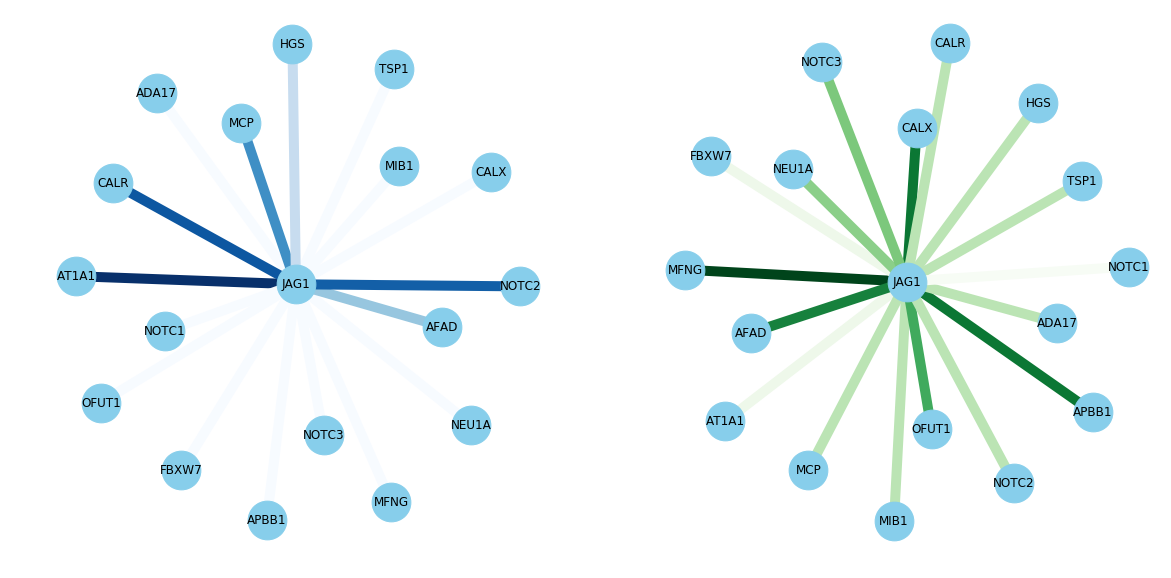

In [394]:
ab = firstdeg_neighbors('JAG1','Kidney')
print(ab)

plt.subplot(121)
G1 = nx.from_pandas_edgelist(ab, 'Gene1', 'Gene2', edge_attr=True)
#G1.xlabel('Edges are ratio of both the nodes > corresponding thresholds')
nx.draw(G1, with_labels=True, node_color='skyblue', node_size=1500, edge_color=ab['Ratios'], width=10.0, edge_cmap=plt.cm.Blues)

plt.subplot(122)
G2 = nx.from_pandas_edgelist(ab, 'Gene1', 'Gene2', edge_attr=True)
nx.draw(G2, with_labels=True, node_color='skyblue', node_size=1500, edge_color=ab['PPI_val'], width=10.0, edge_cmap=plt.cm.Greens)


In [389]:
ef = firstdeg_neighbors('CD4','Blood')
ef

MDR1gene not found in gtex
EI2BDgene not found in gtex
RL22gene not found in gtex
RLA1gene not found in gtex
SIVAgene not found in gtex
RS10gene not found in gtex
TFR1gene not found in gtex
GCRgene not found in gtex
RS19gene not found in gtex
FCG3Agene not found in gtex
TMM11gene not found in gtex
RL7gene not found in gtex
FBW1Agene not found in gtex
HSP7Cgene not found in gtex
POGZgene not found in gtex
HNRH1gene not found in gtex
CC85Cgene not found in gtex
NPMgene not found in gtex
DPA1gene not found in gtex
VPP2gene not found in gtex
IF4A2gene not found in gtex
4F2gene not found in gtex
ARV1gene not found in gtex
TERAgene not found in gtex
CATDgene not found in gtex
VIMEgene not found in gtex
K319Lgene not found in gtex
SDF1gene not found in gtex
MARH4gene not found in gtex
ROA1gene not found in gtex
EI2BGgene not found in gtex
RL18gene not found in gtex
HS90Bgene not found in gtex
EF1Bgene not found in gtex
CH60gene not found in gtex
G3Pgene not found in gtex
VPP1gene not found in

Gene1  Gene2  PPI_val    Ratios
25        CD4   CD44     0.62  0.821229
159       CD4   CD38     0.62  0.782123
722       CD4   P85A     0.52  0.000000
3309      CD4   CD28     0.52  0.815642
3388      CD2    CD4     0.62  0.802607
3389     DPP4    CD4     0.52  0.729981
3390     SDF1    CD4     0.52  0.000000
3391     CCR5    CD4     0.88  0.776536
3392      LAT    CD4     0.62  0.791434
3393     IL16    CD4     0.87  0.000000
3396    U119A    CD4     0.88  0.000000
3397    LYAM1    CD4     0.52  0.000000
3398      PIP    CD4     0.86  0.000000
3399    PI4KA    CD4     0.52  0.301676
3400     CD82    CD4     0.83  0.819367
3401    SPG21    CD4     0.86  0.703911
3402    MARH4    CD4     0.52  0.000000
16276     CD4   CATD     0.62  0.000000
17577     CD4    CD4     0.84  0.821229
23877     CD4  TR10A     0.62  0.000000
26330   KCAB2    CD4     0.73  0.000000
30492     CD4   TFR1     0.62  0.000000
34743     CD4   DPA1     0.62  0.000000
35057     CD4  FCG3A     0.62  0.000000
35543     CD4  IL2RA     0.52  0.821229
35866     CD4   LEG1     0.83  0.000000
36012     CD4   CD53     0.52  0.821229
36114     CD4    CD5     0.52  0.795158
36142     CD4    LCK     0.96  0.821229
36902     CD4  CXCR4     0.88  0.817505
...       ...    ...      ...       ...
90754     CD4   RSSA     0.63  0.000000
90856     CD4   IMB1     0.63  0.000000
90862     CD4  TNPO1     0.63  0.253259
91450     CD4  HSP7C     0.63  0.000000
91456     CD4  HS90A     0.63  0.000000
91460     CD4   CH60     0.63  0.000000
91462     CD4  HS90B     0.63  0.000000
91802     CD4   ROA1     0.63  0.000000
91806     CD4   ROA2     0.63  0.000000
91807     CD4  HNRPD     0.63  0.000000
91808     CD4  HNRH1     0.63  0.000000
97716     CD4   CHIP     0.63  0.000000
102653  PTPRC    CD4     0.65  0.821229
113689    CD4   TERA     0.63  0.000000
125213    CD4    HGS     0.63  0.454376
178590    CD4  RANB9     0.63  0.000000
184568  ADRB2    CD4     0.72  0.687151
231278    CD4   SIVA     0.68  0.000000
294884    CD4   VPP1     0.63  0.000000
298632    CD4   POGZ     0.63  0.000000
298971    CD4   VPP2     0.63  0.000000
299572    CD4  CC85C     0.63  0.000000
318538    CD4  SAAL1     0.63  0.163873
321375    CD4  EI2BD     0.63  0.000000
321377    CD4  EI2BG     0.63  0.000000
321384    CD4  TMM11     0.63  0.000000
321919    CD4   ARV1     0.63  0.000000
323046    CD4  VAMP3     0.63  0.486034
325253    CD4  CD320     0.63  0.245810
336536    CD4  K319L     0.63  0.000000

[111 rows x 4 columns]

MDR1gene not found in gtex
EI2BDgene not found in gtex
RL22gene not found in gtex
RLA1gene not found in gtex
SIVAgene not found in gtex
RS10gene not found in gtex
TFR1gene not found in gtex
GCRgene not found in gtex
RS19gene not found in gtex
FCG3Agene not found in gtex
TMM11gene not found in gtex
RL7gene not found in gtex
FBW1Agene not found in gtex
HSP7Cgene not found in gtex
POGZgene not found in gtex
HNRH1gene not found in gtex
CC85Cgene not found in gtex
NPMgene not found in gtex
DPA1gene not found in gtex
VPP2gene not found in gtex
IF4A2gene not found in gtex
4F2gene not found in gtex
ARV1gene not found in gtex
TERAgene not found in gtex
CATDgene not found in gtex
VIMEgene not found in gtex
K319Lgene not found in gtex
SDF1gene not found in gtex
MARH4gene not found in gtex
ROA1gene not found in gtex
EI2BGgene not found in gtex
RL18gene not found in gtex
HS90Bgene not found in gtex
EF1Bgene not found in gtex
CH60gene not found in gtex
G3Pgene not found in gtex
VPP1gene not found in

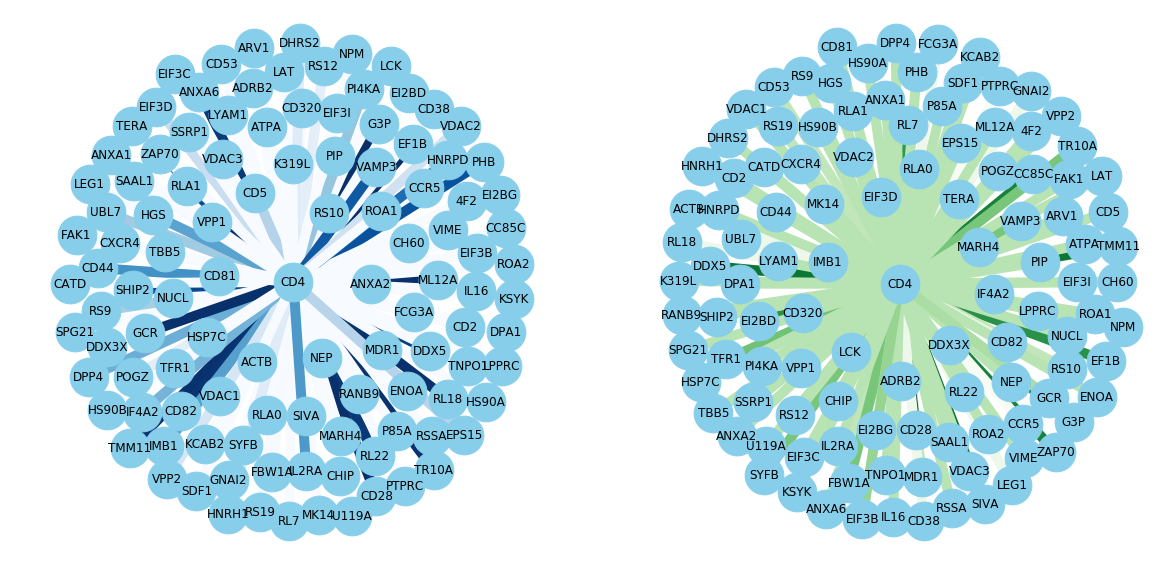

In [395]:
ef = firstdeg_neighbors('CD4','Blood')
print(ef)
plt.subplot(121)
G1 = nx.from_pandas_edgelist(ef, 'Gene1', 'Gene2', edge_attr=True)
#G1.xlabel('Edges are ratio of both the nodes > corresponding thresholds')
nx.draw(G1, with_labels=True, node_color='skyblue', node_size=1500, edge_color=ef['Ratios'], width=10.0, edge_cmap=plt.cm.Blues)

plt.subplot(122)
G2 = nx.from_pandas_edgelist(ef, 'Gene1', 'Gene2', edge_attr=True)
nx.draw(G2, with_labels=True, node_color='skyblue', node_size=1500, edge_color=ef['PPI_val'], width=10.0, edge_cmap=plt.cm.Greens)


In [377]:
# plt.subplot(121)
# G1 = nx.from_pandas_edgelist(ab, 'Gene1', 'Gene2', edge_attr=True)
# #G1.xlabel('Edges are ratio of both the nodes > corresponding thresholds')
# nx.draw(G1, with_labels=True, node_color='skyblue', node_size=1500, edge_color=ab['PPI_val'], width=10.0, edge_cmap=plt.cm.Blues)

# plt.subplot(122)
# G2 = nx.from_pandas_edgelist(ab, 'Gene1', 'Gene2', edge_attr=True)
# nx.draw(G2, with_labels=True, node_color='skyblue', node_size=1500, edge_color=ab['PPI_val'], width=10.0, edge_cmap=plt.cm.Greens)


In [402]:
ls

Disease_Tissue_Gene_masterlist_updated.csv  GTEx_Tissue_Attributes.csv
dtpaper-gtextissue-mapping.csv              GTEx_TPMS_data_skiptop2rows.tsv
gene_exp_dict.p                             GTF_V1.1.ipynb
gene_parameter_df.p                         GTF_V1.2.ipynb
gene_tissue_expression_dict.p               GTF_V1.3.ipynb
gene_tissue_parameter_df.p                  GTF_V1.4.ipynb
gtex_data_hippie_list.tsv                   gt_pairs_frompaper.p
gtex_shortlisted_w_genes_longformat.p       hippie_current.txt
gtex_shortlisted_w_genes.tsv                SC.ipynb


In [419]:
gtex_gene_df = pd.read_csv('GTEx_TPMS_data_skiptop2rows.tsv',usecols=['Name','Description'],sep='\t')

In [422]:
gtex_gene_df.head()

Name Description
0  ENSG00000223972.4     DDX11L1
1  ENSG00000227232.4      WASH7P
2  ENSG00000243485.2  MIR1302-11
3  ENSG00000237613.2     FAM138A
4  ENSG00000268020.2      OR4G4P

In [424]:
gtex_gene_list = list(gtex_gene_df['Description'])
len(gtex_gene_list)

56202

In [426]:
hippie.head()

Gene1  Gene1_Entrezid        Gene2  Gene2_Entrezid  PPI_val  \
0  AL1A1_HUMAN             216  AL1A1_HUMAN             216     0.76   
1   ITA7_HUMAN            3679   ACHA_HUMAN            1134     0.73   
2   NEB1_HUMAN           55607   ACTG_HUMAN              71     0.65   
3   SRGN_HUMAN            5552   CD44_HUMAN             960     0.63   
4   GRB7_HUMAN            2886  ERBB2_HUMAN            2064     0.90   

                                           Procedure  
0  experiments:in vivo,Two-hybrid;pmids:12081471,...  
1  experiments:in vivo,Affinity Capture-Western,a...  
2  experiments:in vitro,in vivo;pmids:9362513,120...  
3  experiments:in vivo;pmids:9334256,16189514,167...  
4  experiments:in vitro,in vivo,Reconstituted Com...

In [427]:
hippie = hippie.dropna()
hippie_gene_list = set(list(hippie['Gene1'])+list(hippie['Gene2']))

In [428]:
hippie_gene_list2 = []
for i in list(hippie_gene_list):
    tokens = i.split('_')
    hippie_gene_list2.append(tokens[0])

In [429]:
hippie_gene_list2[:10]

['CUBN',
 'CTDSL',
 'GPTC4',
 'AN32C',
 'BACE2',
 'SYIC',
 'RN207',
 'CNIH4',
 'TMM56',
 'NSN5C']

In [430]:
common_genes = intersection(gtex_gene_list,hippie_gene_list2)
len(common_genes)

7440